# APA Laboratori 8 - Random Forests                  

In [1]:
set.seed (6046)

## Financial Example: classification model for deposit subscription

Direct marketing campaigns (phone calls) of a Portuguese banking institution. 
 The classification goal is to predict if the client will subscribe a term deposit

In [2]:
deposit <- read.table ("bank-full.csv.gz", header=TRUE, stringsAsFactors=TRUE, sep=";")

dim(deposit)

[1] 45211    17

In [3]:
summary(deposit)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   divorced: 5207   primary  : 6851  
 1st Qu.:33.00   management :9458   married :27214   secondary:23202  
 Median :39.00   technician :7597   single  :12790   tertiary :13301  
 Mean   :40.94   admin.     :5171                    unknown  : 1857  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   no :20081   no :37967   cellular :29285  
 yes:  815   1st Qu.:    72   yes:25130   yes: 7244   telephone: 2906  
             Median :   448                           unknown  :13020  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


 This dataset needs a lot of pre-processing ... also it displays a good mixture of categorical and numeric variables

 age seems OK
 job has 12 values, let's check their frequency

 seems OK

In [4]:
table(deposit$job)


       admin.   blue-collar  entrepreneur     housemaid    management 
         5171          9732          1487          1240          9458 
      retired self-employed      services       student    technician 
         2264          1579          4154           938          7597 
   unemployed       unknown 
         1303           288 

education has 4 values, let's check their frequency

 seems OK

In [5]:
table(deposit$education)


  primary secondary  tertiary   unknown 
     6851     23202     13301      1857 

 month looks very suspicious ... but is OK

In [6]:
table(deposit$month)


  apr   aug   dec   feb   jan   jul   jun   mar   may   nov   oct   sep 
 2932  6247   214  2649  1403  6895  5341   477 13766  3970   738   579 

Duration is highly skewed ...

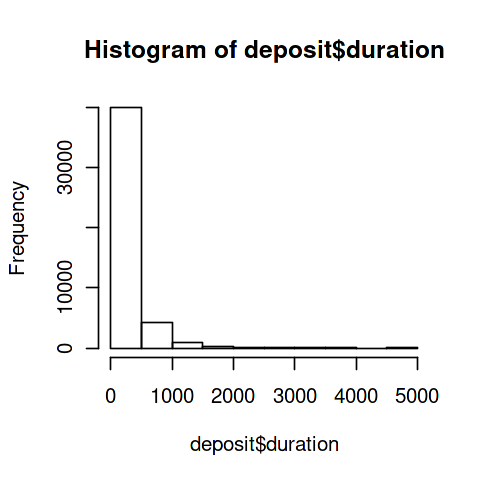

In [7]:
options(repr.plot.width=4, repr.plot.height=4)
hist(deposit$duration)

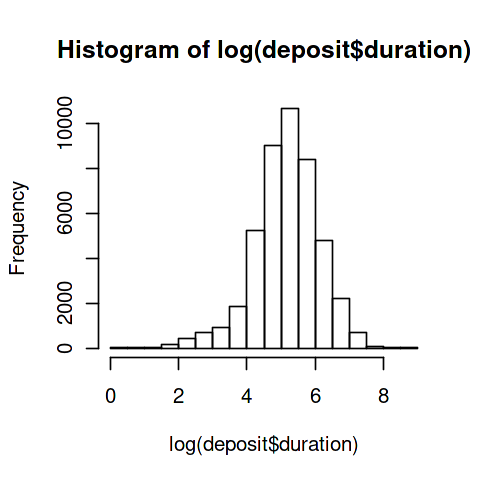

In [8]:
hist(log(deposit$duration))

In [9]:
deposit$duration <- log(deposit$duration+0.001)

 what to do with 'pdays' and 'previous'? it is not clear how to best pre-process them; we shall need
 some financial expertise... we leave them as they are

 The rest seem OK (but it would take a careful analysis, and a lot of domain knowledge)

Let's rename the target ...

In [10]:
colnames(deposit)[ncol(deposit)] <- "subscribed"

dim(deposit)

[1] 45211    17

In [11]:
summary(deposit)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   divorced: 5207   primary  : 6851  
 1st Qu.:33.00   management :9458   married :27214   secondary:23202  
 Median :39.00   technician :7597   single  :12790   tertiary :13301  
 Mean   :40.94   admin.     :5171                    unknown  : 1857  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   no :20081   no :37967   cellular :29285  
 yes:  815   1st Qu.:    72   yes:25130   yes: 7244   telephone: 2906  
             Median :   448                           unknown  :13020  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


Since we want to use different methods, we need CV and a separate test set:

In [15]:
install.packages("TunePareto")
library(TunePareto)

Installing package into ‘/home/bejar/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


precalculate the TR/TE partition and the cross-validation partitions on the TR part

In [16]:
N <- nrow(deposit)
all.indexes <- 1:N

learn.indexes <- sample(1:N, round(2*N/3))
test.indexes <- all.indexes[-learn.indexes]

learn.data <- deposit[learn.indexes,]

nlearn <- length(learn.indexes)
ntest <- N - nlearn

First try a standard decision tree (CART)

In [18]:
install.packages("tree")
library(tree)

model.tree <- tree (subscribed ~ ., data = learn.data)

summary(model.tree)

Installing package into ‘/home/bejar/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)



Classification tree:
tree(formula = subscribed ~ ., data = learn.data)
Variables actually used in tree construction:
[1] "duration" "poutcome" "month"    "contact" 
Number of terminal nodes:  9 
Residual mean deviance:  0.4863 = 14650 / 30130 
Misclassification error rate: 0.1081 = 3259 / 30141 

 so training error rate is 10.72%

In [19]:
model.tree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 30141 21790.0 no ( 0.882718 0.117282 )  
   2) duration < 6.00512 25026 12290.0 no ( 0.933110 0.066890 )  
     4) poutcome: failure,other,unknown 24254  9537.0 no ( 0.950647 0.049353 )  
       8) month: aug,jan,jul,jun,may,nov 20437  5112.0 no ( 0.972746 0.027254 )  
        16) duration < 5.07205 11183  1038.0 no ( 0.992041 0.007959 ) *
        17) duration > 5.07205 9254  3705.0 no ( 0.949427 0.050573 )  
          34) contact: unknown 3419   124.9 no ( 0.997368 0.002632 ) *
          35) contact: cellular,telephone 5835  3215.0 no ( 0.921337 0.078663 )  
            70) month: aug,jan,jul,may,nov 5634  2655.0 no ( 0.936812 0.063188 ) *
            71) month: jun 201   278.5 yes ( 0.487562 0.512438 ) *
       9) month: apr,dec,feb,mar,oct,sep 3817  3452.0 no ( 0.832329 0.167671 )  
        18) month: apr,feb 2911  2033.0 no ( 0.888698 0.111302 ) *
        19) month: dec,mar,oct,sep 906  1172.0 no ( 0.6

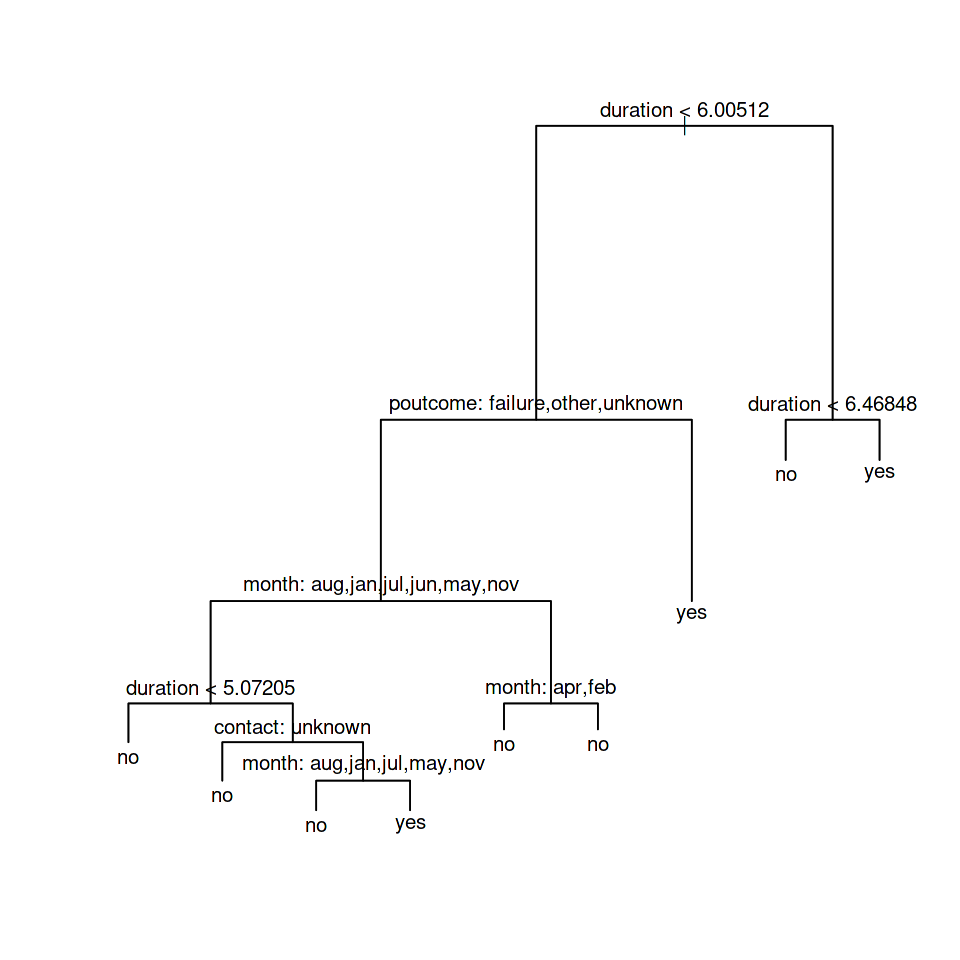

In [20]:
options(repr.plot.width=8, repr.plot.height=8)
plot (model.tree)

text (model.tree,pretty=0)

In [21]:
pred.tree <- predict (model.tree, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.tree))

     Pred
Truth    no   yes
  no  12528   788
  yes   929   825

 We define now a convenience function (the harmonic mean), to compute the F1 accuracy:

In [22]:
harm <- function (a,b) { 2/(1/a+1/b) }

 percent by class

In [23]:
prop.table(ct, 1)

     Pred
Truth         no        yes
  no  0.94082307 0.05917693
  yes 0.52964652 0.47035348

 total percent correct

In [24]:
sum(diag(ct))/sum(ct)

[1] 0.886065

 test error is 

In [25]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 11.39

 not very good, because the 'yes' class is nearly ignored

In [26]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.6271638

 Now a random Forest

In [29]:
install.packages('randomForest')

library(randomForest)

model.rf1 <- randomForest(subscribed ~ ., data = learn.data, ntree=100, proximity=FALSE)

model.rf1

Installing package into ‘/home/bejar/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.



Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.36%
Confusion matrix:
       no  yes class.error
no  25595 1011  0.03799895
yes  1810 1725  0.51202263

We get an estimated test error (OOB) of 9.3%, so better; let's compute the real test error:

In [30]:
pred.rf1 <- predict (model.rf1, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf1))

     Pred
Truth    no   yes
  no  12780   536
  yes   905   849

percent by class

In [32]:
prop.table(ct, 1)

     Pred
Truth         no        yes
  no  0.95974767 0.04025233
  yes 0.51596351 0.48403649

 total percent correct

In [33]:
sum(diag(ct))/sum(ct)

[1] 0.9043796

real test error is 

In [34]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 9.56

and The F1-score

In [35]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.6435212

So OOB really works in estimating prediction error and the RF is better than a single tree; 
 however, there is a big issue in unbalanced classes

 one way to deal with this is to include class weights

In [37]:
model.rf2 <- randomForest(subscribed ~ ., data = learn.data, ntree=100, proximity=FALSE, classwt=c(1,10))

model.rf2


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE, classwt = c(1, 10)) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.76%
Confusion matrix:
       no  yes class.error
no  25724  882  0.03315042
yes  2061 1474  0.58302687

which helps a little bit, but not much: we get estimated test error (OOB) of 9.86% with a better balance; let's compute the real test error:

In [38]:
pred.rf2 <- predict (model.rf2, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf2))

     Pred
Truth    no   yes
  no  12893   423
  yes  1054   700

percent by class

In [39]:
prop.table(ct, 1)

     Pred
Truth        no       yes
  no  0.9682337 0.0317663
  yes 0.6009122 0.3990878

 total percent correct

In [40]:
sum(diag(ct))/sum(ct)

[1] 0.9019907

real test error is 

In [41]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 9.8

and the F1-score

In [42]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.5652076

 another way is to stratify the sampling in the boostrap resamples

 'yes' is the less represented class, so we upsample it

In [43]:
n.yes <- table(learn.data$subscribed)["yes"]
n.no <- table(learn.data$subscribed)["no"]

model.rf3 <- randomForest(subscribed ~ ., data = learn.data, ntree=100, proximity=FALSE, 
                          sampsize=c(yes=3000, no=3000), strata=learn.data$subscribed)

model.rf3


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE, sampsize = c(yes = 3000, no = 3000), strata = learn.data$subscribed) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 14.25%
Confusion matrix:
       no  yes class.error
no  22771 3835   0.1441404
yes   461 3074   0.1304102

which seems to help much more: we get estimated test error (OOB) of 14.4% with a very good balance
 let's compute the real test error:

In [27]:
pred.rf3 <- predict (model.rf3, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf3))

ERROR: Error in predict(model.rf3, deposit[test.indexes, ], type = "class"): objeto 'model.rf3' no encontrado


 percent by class

In [28]:
prop.table(ct, 1)

ERROR: Error in sweep(x, margin, margin.table(x, margin), "/", check.margin = FALSE): objeto 'ct' no encontrado


 total percent correct

In [29]:
sum(diag(ct))/sum(ct)

ERROR: Error in diag(ct): objeto 'ct' no encontrado


real test error is 

In [30]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

ERROR: Error in diag(ct): objeto 'ct' no encontrado


and F1-score

In [31]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

ERROR: Error in harm(prop.table(ct, 1)[1, 1], prop.table(ct, 1)[2, 2]): no se pudo encontrar la función "harm"


 Now we can try to optimize the number of trees, guided by OOB:

In [45]:
(ntrees <- round(10^seq(1,3,by=0.2)))

[1]   10   16   25   40   63  100  158  251  398  631 1000

prepare the structure to store the partial results

In [46]:
rf.results <- matrix (rep(0,2*length(ntrees)),nrow=length(ntrees))
colnames (rf.results) <- c("ntrees", "OOB")
rf.results[,"ntrees"] <- ntrees
rf.results[,"OOB"] <- 0

ii <- 1

for (nt in ntrees)
{ 
  print(nt)

  model.rf <- randomForest(subscribed ~ ., data = learn.data, ntree=nt, proximity=FALSE, 
                          sampsize=c(yes=3000, no=3000), strata=learn.data$subscribed)
  
  # get the OOB
  rf.results[ii,"OOB"] <- model.rf$err.rate[nt,1]

  ii <- ii+1
}

[1] 10
[1] 16
[1] 25
[1] 40
[1] 63
[1] 100
[1] 158
[1] 251
[1] 398
[1] 631
[1] 1000


In [47]:
rf.results

ntrees,OOB
10,0.1531262
16,0.1477390
25,0.1481039
40,0.1419993
63,0.1438240
100,0.1431937
158,0.1430941
251,0.1427955
398,0.1432600
631,0.1420988


 choose best value of 'ntrees'

In [49]:
lowest.OOB.error <- as.integer(which.min(rf.results[,"OOB"]))
(ntrees.best <- rf.results[lowest.OOB.error,"ntrees"])

ntrees 
    40

we could also try to optimize the number of variables in the same way, though the default values work quite well in general

Now refit the RF with the best value of 'ntrees'

In [50]:
model.rf <- randomForest(subscribed ~ ., data = learn.data, ntree=ntrees.best, proximity=FALSE, 
                         sampsize=c(yes=3000, no=3000), strata=learn.data$subscribed)

 let's compute the real test error:

In [51]:
pred.rf.final <- predict (model.rf, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf.final))

     Pred
Truth    no   yes
  no  11364  1952
  yes   249  1505

percent by class

In [52]:
prop.table(ct, 1)

     Pred
Truth        no       yes
  no  0.8534094 0.1465906
  yes 0.1419612 0.8580388

 total percent correct

In [53]:
sum(diag(ct))/sum(ct)

[1] 0.8539482

 real test error is 

In [54]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 14.61

and the F1-score

In [55]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.8557178

And this is the final model

In [56]:
print(model.rf)


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = ntrees.best,      proximity = FALSE, sampsize = c(yes = 3000, no = 3000), strata = learn.data$subscribed) 
               Type of random forest: classification
                     Number of trees: 40
No. of variables tried at each split: 4

        OOB estimate of  error rate: 14.44%
Confusion matrix:
       no  yes class.error
no  22758 3848   0.1446290
yes   505 3030   0.1428571


 The importance of variables

,MeanDecreaseGini
age,203.961082
job,166.132299
marital,48.848567
education,56.867997
default,3.142407
balance,219.518004
housing,78.675028
loan,23.291985
contact,110.433764
day,186.545763


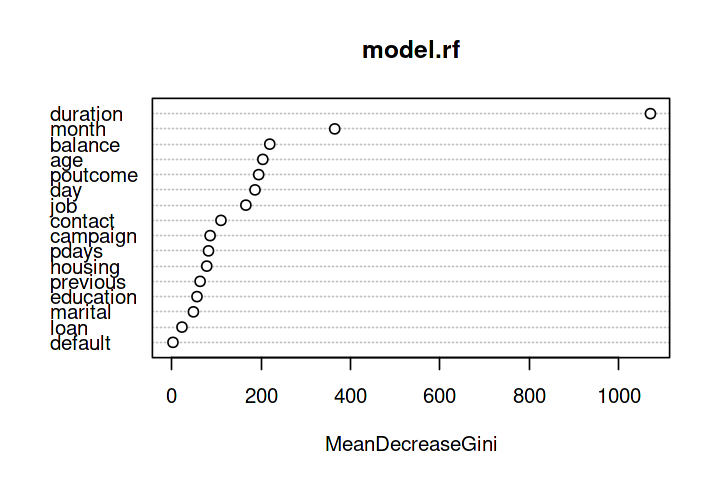

In [57]:
importance(model.rf)
options(repr.plot.width=6, repr.plot.height=4)
varImpPlot(model.rf)

 'duration' is the most important variable, then month, etc

 plot error rate: black = out of bag (OOB), red = label 1 ('no'), green  = label 2 ('yes')
 as a function of the number of trees used

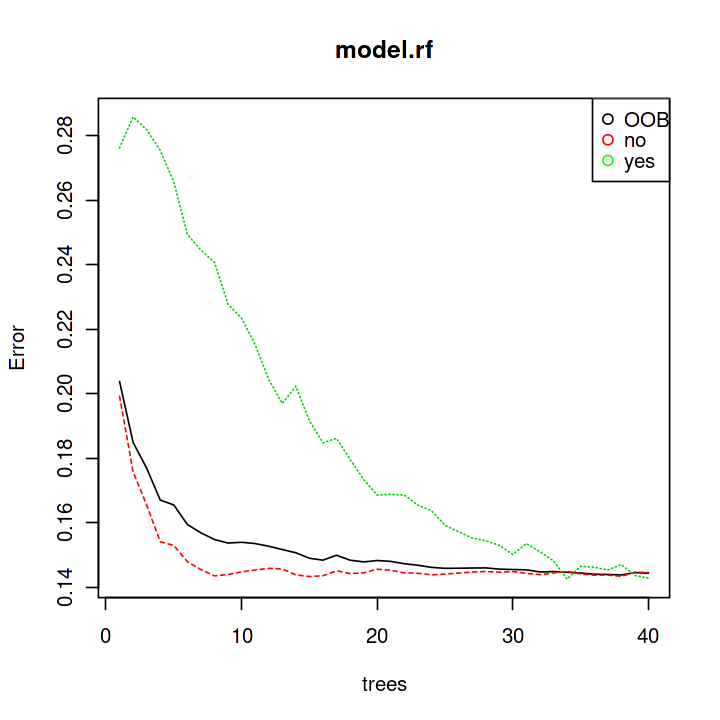

In [58]:
options(repr.plot.width=6, repr.plot.height=6)
plot(model.rf)

legend("topright", legend=c("OOB", "no", "yes"),    
       pch=c(1,1), col=c("black","red","green"))

 What variables are being used in the forest (their counts)

In [59]:
varUsed(model.rf, by.tree=FALSE,count = TRUE)

[1] 4623 3138 1466 1805  116 5116  685  656  786 4313 3158 5685 2516 1382  959
[16]  594